# Factor trading using Bayesian Neural Networks

**Names:** Andrew Zabelo, Daniel Wen, Kyle McCandless  
**Student IDs:** 2176083, 2159859, 2157818

## Setup

### Imports

In [1]:
# General
import os
import random
import numpy as np
import pandas as pd
import warnings
import statsmodels.api as sm

# Plotting
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime

# ML tools
import torch
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split

# BNN specific
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn
from pyro.infer import MCMC, NUTS
from pyro.infer import Predictive

# We'll suppress some warnings from tensorflow, but feel free to
# comment out this line and see some of the efficiency gains we can get!
warnings.filterwarnings("ignore")

### General helper functions

In [2]:
# Calculates returns and prints the returns mean, vol, and Sharpe ratio for a strategy
def analyze(returns, strat_name):
    strat_mean = returns.mean()
    strat_vol = returns.std()
    strat_sharpe = strat_mean / strat_vol
    print(f"\n\n{strat_name} daily returns:")
    print(f"Mean = {strat_mean:.3f}%")
    print(f"Volatility = {strat_vol:0.3f}%")
    print(f"Sharpe Ratio = {strat_sharpe:0.3f}")
    
# Plots the cumulative returns for a strategy versus the market returns and the CAPM-implied returns
def plot_cum_returns(dates, returns, mktrf_returns, rf_returns, beta, strat_name, log):
    implied_returns = rf_returns + beta * mktrf_returns
    mkt_returns = rf_returns + mktrf_returns 
    
    dates = [datetime.datetime.strptime(str(date), '%Y%m%d') for date in dates]
    strategy_cumulative = (returns / 100 + 1.0).cumprod()
    market_cumulative = (mkt_returns / 100 + 1.0).cumprod()
    mir_cumulative = (implied_returns / 100 + 1.0).cumprod()

    # Set axis scales
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    if log: ax.set_yscale('log')
    
    # Plot data
    ax.plot(dates, strategy_cumulative, label=f'{strat_name} Portfolio Value')
    ax.plot(dates, market_cumulative, label=f'Market Portfolio Value')
    ax.plot(dates, mir_cumulative, label=f'CAPM-Implied Portfolio Value')
    
    plt.title(f'{strat_name} Model Performance')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Portfolio Value')

    plt.legend()
    plt.show()

# Note: All io_fns and model_fns start with an 'io_' and 'model_' prefix
# respectively
def fitting_returns_data(data_path,
                         io_fn,
                         model_fn,
                         strat_name,
                         seed = None,
                         print_summary = True,
                         log = False):
    # if given, set the random seed
    if seed:
        set_seed(seed)

    # Load the data into a pandas DataFrame
    data = pd.read_csv(data_path)
    # Save for plotting
    dates = data.iloc[:,0]
    rf_returns = data.iloc[:,7]
    mktrf_returns = data.iloc[:,1]
    # Drop date and risk free rate
    data = data.iloc[:, 1:7]

    # Shift the data by one time step to create input/output pairs
    X, y = io_fn(data)
    
    # Fix lengths for plotting
    shift_amt = len(data) - len(X)
    dates = dates[shift_amt:]
    rf_returns = rf_returns[shift_amt:]
    mktrf_returns = mktrf_returns[shift_amt:]

    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

    # Fit the model
    strat_df, return_vector = model_fn(X, y, X_train, y_train, X_val, y_val)

    # Calculate alpha
    y_ols = sm.add_constant(y)
    model_OLS = sm.OLS(return_vector, y_ols).fit()
    if print_summary:
        print(model_OLS.summary())
        
    # Print Sharpe Ratio
    analyze(return_vector, strat_name)
    
    # Plot cumulative returns
    plot_cum_returns(dates, return_vector, mktrf_returns, rf_returns, model_OLS.params[1], strat_name, log)

    return strat_df, return_vector, model_OLS

def set_seed(seed_value):
    # Adding a fixed seed from this solution: https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras
    # 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED']=str(seed_value)

    # 2. Set the `python` built-in pseudo-random generator at a fixed value
    random.seed(seed_value)

    # 3. Set the `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed_value)

    # 4. Set the `tensorflow` pseudo-random generator at a fixed value
    tf.compat.v1.set_random_seed(seed_value)
    return

def predictions_to_returns(pred_df, y):
    # Given the predictions of each factor for each day, calculate our
    # strategy for each day, and the returns for each day

    # Apply our strategy to our predictions
    strat_df = pred_df.apply(lambda row : max_predicted_factor_strat(row), axis = 1)

    # Calculate our returns
    return_vector = np.multiply(strat_df,np.asarray(y)).apply(sum, axis = 1)

    return strat_df, return_vector

def predictions_to_returns_max_sharpe(pred_df, std_df, y):
    # Given the predictions of each factor for each day, calculate our
    # strategy for each day, and the returns for each day

    # Apply our strategy to our predictions
    comb_df = pred_df / std_df
    strat_df = comb_df.apply(lambda row : max_predicted_factor_strat(row), axis = 1)

    # Calculate our returns
    return_vector = np.multiply(strat_df,np.asarray(y)).apply(sum, axis = 1)

    return strat_df, return_vector

def max_predicted_factor_strat(row):
    # For each day, set our strategy to be the factor with
    # the highest predicted return
    max_pred_return = max(row)
    row_list = [x == max_pred_return for x in row]
    return pd.Series(row_list)

### IO functions (data manipulation)

In [3]:
def io_day_1_lag(data):
    # Create input output pairs, where the input is the previous day of data
    # and the output is the current day of data.
    X = data.shift(1).dropna().reset_index(drop=True)
    y = data.dropna().iloc[1:,:].reset_index(drop=True)
    return X, y

def io_day_5_lag(data):
    X = data.shift(1).add_suffix('_lag1')
    for i in range(2, 6):
        shifted_data = data.shift(i).add_suffix('_lag{}'.format(i))
        X = pd.concat([X, shifted_data], axis=1)
    X = X.dropna().reset_index(drop=True)
    y = data.iloc[5:,:].reset_index(drop=True)
    return X, y

### Model definitions

In [28]:
def model_feed_forward(X, y, X_train, y_train, X_val, y_val):
    # Define the neural network model
    model = Sequential()
    model.add(Dense(32, activation='relu', input_shape=(X.shape[1],)))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(6, activation='linear'))

    # Compile the model
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Train the model, verbose = 0 means reports aren't printed
    # at the end of each epoch
    model.fit(X_train, y_train, batch_size=32, epochs=50,
              validation_data=(X_val, y_val))

    # Make predictions
    predictions = model.predict(X)

    pred_df = pd.DataFrame(predictions)

    return predictions_to_returns(pred_df, y)

# Definition for a basic BNN as a proof of concept
class BasicBNN(PyroModule):
    def __init__(self, in_dim=6, out_dim=6, hid_dim=10, prior_scale=1.):
        super().__init__()

        self.activation = nn.Tanh()  # or nn.ReLU()
        self.layer1 = PyroModule[nn.Linear](in_dim, hid_dim)  # Input to hidden layer
        self.layer2 = PyroModule[nn.Linear](hid_dim, out_dim)  # Hidden to output layer

        # Set layer parameters as random variables
        self.layer1.weight = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim, in_dim]).to_event(2))
        self.layer1.bias = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim]).to_event(1))
        self.layer2.weight = PyroSample(dist.Normal(0., prior_scale).expand([out_dim, hid_dim]).to_event(2))
        self.layer2.bias = PyroSample(dist.Normal(0., prior_scale).expand([out_dim]).to_event(1))

    def forward(self, x, y=None):
        x = self.activation(self.layer1(x))
        mu = self.layer2(x).squeeze()
        sigma = pyro.sample("sigma", dist.Gamma(0.5, 2.0))  # Infer the response noise

        # Sampling model
        with pyro.plate("data", 6):
            obs = pyro.sample("obs", dist.Normal(mu, sigma*sigma), obs=y)
        return mu
    
# Calculate returns and alphas using basic BNN with 1 day lag
def model_basic_bnn(X, y, X_train, y_train, X_val, y_val):
    # Convert data
    x_train_tensor = torch.tensor(X_train.values).float()
    y_train_tensor = torch.tensor(y_train.values).float()
    x_val_tensor = torch.tensor(X_val.values).float()
    x_val_tensor = torch.tensor(y_val.values).float()
    x_tensor = torch.tensor(X.values).float()
    y_tensor = torch.tensor(y.values).float()

    # Define the neural network model
    model = BasicBNN()

    # Set Pyro random seed
    pyro.set_rng_seed(COMMON_SEED)

    # Define Hamiltonian Monte Carlo (HMC) kernel
    # NUTS = "No-U-Turn Sampler" (https://arxiv.org/abs/1111.4246), gives HMC an adaptive step size
    nuts_kernel = NUTS(model, jit_compile=True) # jit_compile=True is faster but requires PyTorch 1.6+

    # Define MCMC sampler, get 50 posterior samples
    mcmc = MCMC(nuts_kernel, num_samples=20)

    # Run MCMC
    mcmc.run(x_train_tensor, y_train_tensor)

    # Make predictions
    predictive = Predictive(model=model, posterior_samples=mcmc.get_samples())
    preds = predictive(x_tensor)
    
    pred_means = preds['obs'].T.detach().numpy().mean(axis=2)
    pred_df = pd.DataFrame(pred_means.T)
    
    return predictions_to_returns(pred_df, y)
    
# Advanced BNN that has been parameter tuned.
# ReLU activation function, 5 day lag, hid_dim=50
class AdvancedBNN(PyroModule):
    def __init__(self, in_dim=30, out_dim=6, hid_dim=50, prior_scale=1.):
        super().__init__()

        self.activation = nn.ReLU()
        self.layer1 = PyroModule[nn.Linear](in_dim, hid_dim)  # Input to hidden layer
        self.layer2 = PyroModule[nn.Linear](hid_dim, out_dim)  # Hidden to output layer

        # Set layer parameters as random variables
        self.layer1.weight = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim, in_dim]).to_event(2))
        self.layer1.bias = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim]).to_event(1))
        self.layer2.weight = PyroSample(dist.Normal(0., prior_scale).expand([out_dim, hid_dim]).to_event(2))
        self.layer2.bias = PyroSample(dist.Normal(0., prior_scale).expand([out_dim]).to_event(1))

    def forward(self, x, y=None):
        x = self.activation(self.layer1(x))
        mu = self.layer2(x).squeeze()
        sigma = pyro.sample("sigma", dist.Gamma(0.5, 2.0))  # Infer the response noise

        # Sampling model
        with pyro.plate("data", 6):
            obs = pyro.sample("obs", dist.Normal(mu, sigma*sigma), obs=y)
        return mu
    
# Calculate returns and alphas using basic BNN with 1 day lag
def model_advanced_bnn(X, y, X_train, y_train, X_val, y_val):
    # Convert data
    x_train_tensor = torch.tensor(X_train.values).float()
    y_train_tensor = torch.tensor(y_train.values).float()
    x_val_tensor = torch.tensor(X_val.values).float()
    x_val_tensor = torch.tensor(y_val.values).float()
    x_tensor = torch.tensor(X.values).float()
    y_tensor = torch.tensor(y.values).float()

    # Define the neural network model
    model = AdvancedBNN()

    # Set Pyro random seed
    pyro.set_rng_seed(COMMON_SEED)

    # Define Hamiltonian Monte Carlo (HMC) kernel
    # NUTS = "No-U-Turn Sampler" (https://arxiv.org/abs/1111.4246), gives HMC an adaptive step size
    nuts_kernel = NUTS(model, jit_compile=True) # jit_compile=True is faster but requires PyTorch 1.6+

    # Define MCMC sampler, get 50 posterior samples
    mcmc = MCMC(nuts_kernel, num_samples=30)

    # Run MCMC
    mcmc.run(x_train_tensor, y_train_tensor)

    # Make predictions
    predictive = Predictive(model=model, posterior_samples=mcmc.get_samples())
    preds = predictive(x_tensor)
    
    pred_means = preds['obs'].T.detach().numpy().mean(axis=2)
    pred_df = pd.DataFrame(pred_means.T)
    
    return predictions_to_returns(pred_df, y)
    
# Calculate returns and alphas using basic BNN with 1 day lag
def model_sharpe_bnn(X, y, X_train, y_train, X_val, y_val):
    # Convert data
    x_train_tensor = torch.tensor(X_train.values).float()
    y_train_tensor = torch.tensor(y_train.values).float()
    x_val_tensor = torch.tensor(X_val.values).float()
    x_val_tensor = torch.tensor(y_val.values).float()
    x_tensor = torch.tensor(X.values).float()
    y_tensor = torch.tensor(y.values).float()

    # Define the neural network model
    model = AdvancedBNN()

    # Set Pyro random seed
    pyro.set_rng_seed(COMMON_SEED)

    # Define Hamiltonian Monte Carlo (HMC) kernel
    # NUTS = "No-U-Turn Sampler" (https://arxiv.org/abs/1111.4246), gives HMC an adaptive step size
    nuts_kernel = NUTS(model, jit_compile=True) # jit_compile=True is faster but requires PyTorch 1.6+

    # Define MCMC sampler, get 50 posterior samples
    mcmc = MCMC(nuts_kernel, num_samples=30)

    # Run MCMC
    mcmc.run(x_train_tensor, y_train_tensor)

    # Make predictions
    predictive = Predictive(model=model, posterior_samples=mcmc.get_samples())
    preds = predictive(x_tensor)
    
    pred_means = preds['obs'].T.detach().numpy().mean(axis=2)
    pred_df = pd.DataFrame(pred_means.T)
    
    pred_stds = preds['obs'].T.detach().numpy().std(axis=2)
    std_df = pd.DataFrame(pred_stds.T)
    return predictions_to_returns_max_sharpe(pred_df, std_df, y)

## Establish the Benchmark

### HW5 best feed forward model

Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - loss: 0.5215 - val_loss: 0.4179
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 0.4602 - val_loss: 0.4127
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 0.4514 - val_loss: 0.4120
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 0.4460 - val_loss: 0.4118
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - loss: 0.4417 - val_loss: 0.4121
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 0.4378 - val_loss: 0.4129
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step - loss: 0.4339 - val_loss: 0.4132
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 0.4304 - val_loss: 0.4136
Epoch 9/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step - loss: 0.4262 - val_loss: 0.4154
Epoch 10/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - loss: 0.4225 - val_loss: 0.4164
Epoch 11/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step - loss: 0.4192 - val_loss: 0.4175
Epoch 12/50
375/375 ━━━━━━━━━━

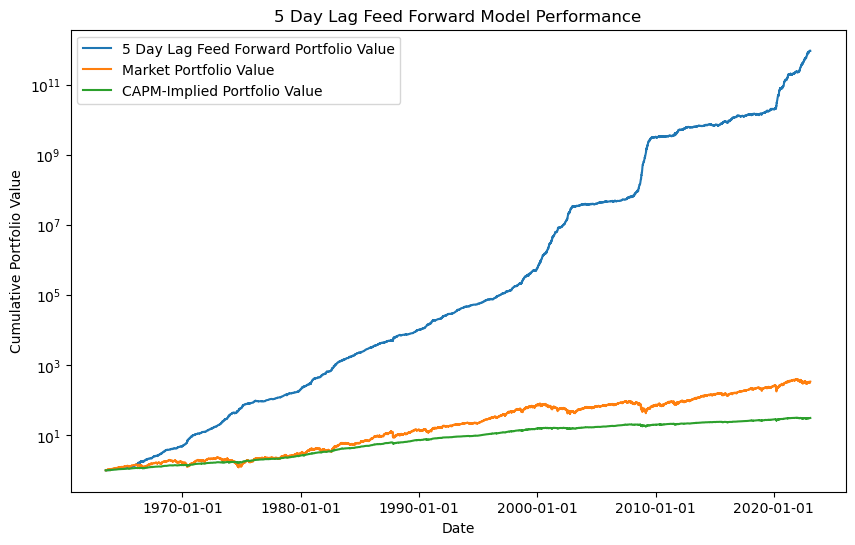

In [5]:
COMMON_SEED = 123

# Calculate returns and alphas using the feed forward neural net with
# five day lagged input variables.
fitting_returns_data(
    'ff6_factors_19630701_20230131.csv',
    io_day_5_lag,
    model_feed_forward,
    "5 Day Lag Feed Forward",
    seed = COMMON_SEED,
    log = True);

## Predicting Factor returns using a Bayesian Neural Network

### Train a basic BNN and analyze performance

Sample: 100%|████| 40/40 [00:09,  4.44it/s, step size=1.04e-02, acc. prob=0.198]


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     303.2
Date:                Thu, 06 Jun 2024   Prob (F-statistic):               0.00
Time:                        13:11:20   Log-Likelihood:                -14468.
No. Observations:               14998   AIC:                         2.895e+04
Df Residuals:                   14991   BIC:                         2.900e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0240      0.005      4.612      0.0

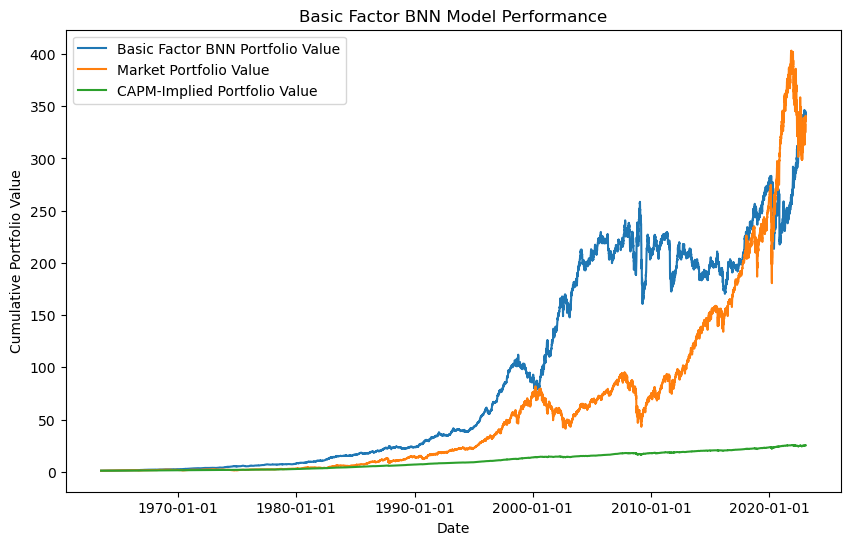

In [14]:
fitting_returns_data(
    'ff6_factors_19630701_20230131.csv',
    io_day_1_lag,
    model_basic_bnn,
    "Basic Factor BNN",
    seed = COMMON_SEED);

## Advanced BNN: 5 day lag, multiple hidden layers

Warmup:   0%|                                              | 0/40 [16:08, ?it/s]


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     390.0
Date:                Thu, 06 Jun 2024   Prob (F-statistic):               0.00
Time:                        13:35:11   Log-Likelihood:                -15778.
No. Observations:               14994   AIC:                         3.157e+04
Df Residuals:                   14987   BIC:                         3.162e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1097      0.006     19.314      0.0

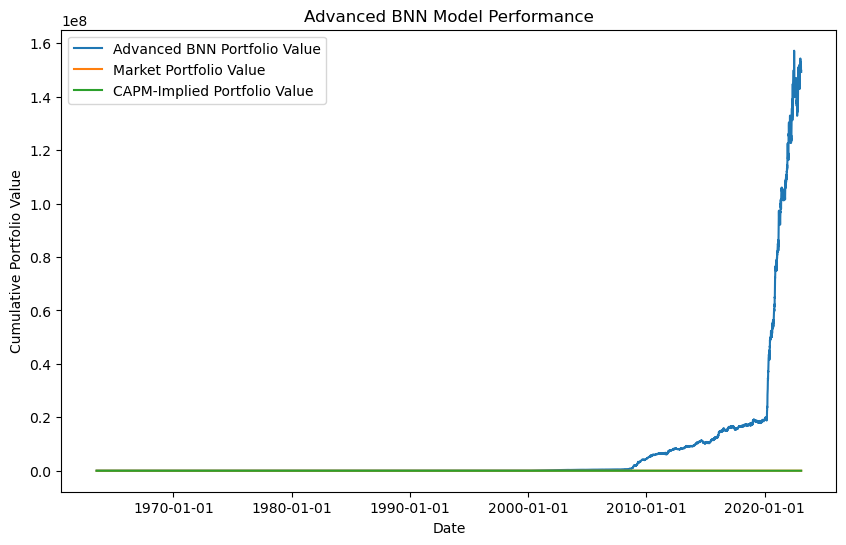

In [24]:
fitting_returns_data(
    'ff6_factors_19630701_20230131.csv',
    io_day_5_lag,
    model_advanced_bnn,
    "Advanced BNN",
    seed = COMMON_SEED,
    log = True);

### Change to max Sharpe Ratio

In [ ]:
fitting_returns_data(
    'ff6_factors_19630701_20230131.csv',
    io_day_5_lag,
    model_sharpe_bnn,
    "Sharpe Ratio BNN",
    seed = COMMON_SEED,
    log = True);

Sample:  55%|██▏ | 33/60 [02:29, 18.94s/it, step size=1.23e-03, acc. prob=0.839]

## Robustness to P-Hacking